# History variables

* Volume average := $$[q]_p \equiv\sum q \Theta(p)\Delta V / \sum \Delta V$$
* Area average := $$\langle q_k \rangle_p \equiv \frac{\sum_{i,j}q_k\Theta(p)\Delta x \Delta y}{L_x L_y}$$
* Default variables:
    * time, dt
    * mass = $[\rho]$
    * totalE = $[E]$
    * x(1/2/3)Mom = $[\rho v_{(1/2/3)}]$
    * x(1/2/3)KE = $[E_{k,(1/2/3)}=\rho v_{(1/2/3)}^2/2]$
    * x(1/2/3)ME = $[B_{1/2/3}^2/2]$
    * gravPE = $[\rho\Phi]$
* Additional variables:
    * heat_ratio = $[\Gamma/\Gamma_0]$
    * x2dke = $[\delta E_{k,2}=\rho (v_2+q\Omega x)^2/2]$
    * x(1/2/3)KE_2p = $[\delta E_{k,(1/2/3)}]_{2p}$, where $2p=c+u+w$
    * F3(h2/h1/w/u/c) = 
    $0.5 ( \langle (\rho v_3)_{k=ke+1}\rangle_{(h2/h1/w/u/c)} - \langle (\rho v_3)_{k=ks}\rangle_{(h2/h1/w/u/c)})$
    * H2 = $[\rho z^2]$
    * H2(h2/h1/w/u/c) = $[\rho z^2](h2/h1/w/u/c)$
    * P = $[P]$
    * Pth(_2p) = $ \langle P_{k = kmid-1} + P_{k =kmid}\rangle_{(2p)} /2$, where $kmid= ks+ Nz/2 -1$
    * Pturb(_2p) = $\langle (\rho v_3^2)_{k = kmid-1} + (\rho v_3^2)_{k =kmid}\rangle_{(2p)}/2$
    * nmid(_2p) = $\langle \rho_{k = kmid-1} + \rho_{k =kmid}\rangle_{(2p)}/2$
    * Vmid_2p = $\langle \Theta(2p) \rangle/2$
    * V(h2/h1/w/u/c) = $[\Theta(h2/h1/w/u/c)]$
    * M(h2/h1/w/u/c) = $[\rho\Theta(h2/h1/w/u/c)]$
    * B(1/2/3) = $[B_{i,(1/2/3)}]$
    * sfr(10/40/100) = $\Sigma_{\rm SFR} (\Delta t =  (10/40/100){\rm Myr})$
    * msp = $[M_{\rm sp}/\Delta V]$ if a grid zone (i,j,k) has star particles
    * mghost = $[\rho]$ if a grid zone (i,j,k) is in control volume of star particles

# packages to be used
 * matplotlib http://matplotlib.org/
 * numpy
 * pandas http://pandas.pydata.org/
 * astropy http://www.astropy.org/

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.__version__

'2.0.1'

In [3]:
import numpy
numpy.__version__

'1.12.1'

In [4]:
import pandas
pandas.__version__

u'0.19.2'

In [5]:
import astropy
astropy.__version__

u'1.3.2'

In [6]:
import sys
sys.path.pop(1) # to remove python path for my old library. you may not need this!
sys.path.insert(0,'../')

In [12]:
from pyathena import ath_hst

ath_hst.__file__

'/tigress/changgoo/pyathena-TIGRESS/pyathena/ath_hst.pyc'

# ath_hst.py

* Athena history dump can be found under the directory "id0/" with an extension ".hst"
* To read the history dump, "ath_hst.py" can be used.
* There are two functions you can use:
    * hst = ath_hst.read(hstfilename)
        * uses standard ascii io to read in the history dump
        * returns a distionary with keys corresponding to the history variable
        * using each key, you can retrive sequence of data as a numpy array
    * hst = ath_hst.read_w_pandas(hstfilename,write=True)
        * uses pandas packages to read in the history dump
        * returns pandas DataFrame contains all the information
        * if write=True, it automatically write the DataFrame to "pickle"
        * if there is a pickle file with filename = hstfilename + '.p', and the pickle file is newer than the original history file, it automatically read the "pickle" file, which is much faster than original ascii file
        * SN history dump can also be accessed with this function

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy

In [14]:
basedir='/tigress/changgoo/'
id='MHD_4pc_new'
hstfilename=basedir+id+'/id0/'+id+'.hst'

### Note that there are three "4pc" models
* MHD_4pc: old feedback with standard box size (1024,1024,4096)pc
* MHD_4pc_T2: old feedback with tall box size (1024,1024,8960)pc; use longer and stronger turbulence driving
* MHD_4pc_new: new feedback with tall box size (1024,1024,7168)pc

In [15]:
hst=ath_hst.read(hstfilename)

Reading a history file:/tigress/changgoo/MHD_4pc_new/id0/MHD_4pc_new.hst


In [16]:
print hst.keys()

['Vmid_2p', 'F3c', 'vol', 'gravPE', 'F3w', 'Vh1', 'x3KE', 'H2u', 'x3ME', 'totalE', 'x3Mom', 'sfr100', 'Mh2', 'x2Mom', 'Mh1', 'Pturb_2p', 'Vw', 'nmid_2p', 'Pturb', 'msp', 'mghost', 'x1KE_2p', 'H2h2', 'H2h1', 'nmid', 'x1Mom', 'heat_ratio', 'sfr40', 'B1', 'x1KE', 'Mc', 'x2ME', 'H2w', 'Pth_2p', 'x2KE', 'Mu', 'P', 'Mw', 'x1ME', 'F3h1', 'F3h2', 'dt', 'Vh2', 'H2c', 'x2dke', 'sfr10', 'Vc', 'x2KE_2p', 'Pth', 'H2', 'B3', 'x3KE_2p', 'mass', 'Vu', 'B2', 'time', 'F3u']


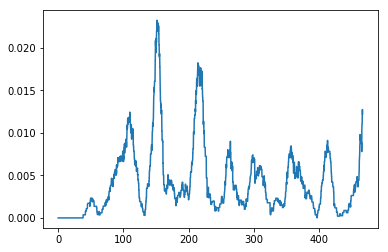

In [17]:
plt.plot(hst['time'],hst['sfr10'])

In [18]:
hstp=ath_hst.read_w_pandas(hstfilename)

Reading a history file:/tigress/changgoo/MHD_4pc_new/id0/MHD_4pc_new.hst.p


In [19]:
hstp

,time,dt,mass,totalE,x1Mom,x2Mom,x3Mom,x1KE,x2KE,x3KE,...,Mu,Mc,B1,B2,B3,sfr10,sfr40,sfr100,msp,mghost
0,0.000000,0.009592,0.051455,7.905256,-1.394652e-17,6.400300e-17,-2.888704e-17,0.768830,2.569448,0.825649,...,0.000000,0.000000e+00,0.000000e+00,0.251638,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.105621,0.009610,0.051455,7.595156,-2.683253e-09,3.153124e-05,5.940351e-09,0.776731,2.576861,0.833737,...,0.000000,0.000000e+00,1.022176e-09,0.251635,4.847600e-19,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.201731,0.009613,0.051455,7.474696,-5.414994e-09,5.904669e-05,1.139693e-08,0.783713,2.583584,0.840712,...,0.000000,0.000000e+00,5.272955e-09,0.251632,2.698859e-19,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.307572,0.009635,0.051455,7.387897,-8.503197e-09,8.780510e-05,1.831912e-08,0.791153,2.590946,0.847950,...,0.000000,0.000000e+00,1.646384e-08,0.251627,9.469526e-19,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.404160,0.009693,0.051455,7.328030,-1.087595e-08,1.124027e-04,2.539763e-08,0.797691,2.597605,0.854125,...,0.001308,0.000000e+00,3.490673e-08,0.251622,6.304345e-19,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.501460,0.009779,0.051455,7.278288,-1.291117e-08,1.353393e-04,3.499797e-08,0.804007,2.604227,0.859902,...,0.017562,0.000000e+00,6.233540e-08,0.251617,-1.542810e-19,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.609611,0.009893,0.051455,7.231047,-1.563424e-08,1.583344e-04,4.717303e-08,0.810669,2.611447,0.865762,...,0.023749,0.000000e+00,1.014025e-07,0.251611,-5.140280e-19,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.708810,0.009956,0.051455,7.192970,-1.807745e-08,1.767827e-04,6.158298e-08,0.816406,2.617897,0.870576,...,0.026899,0.000000e+00,1.410212e-07,0.251605,1.421503e-18,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.808702,0.010032,0.051455,7.158440,-1.918636e-08,1.924593e-04,7.840075e-08,0.821780,2.624178,0.874839,...,0.028986,0.000000e+00,1.789726e-07,0.251598,-1.900560e-18,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.909274,0.010085,0.051455,7.126727,-2.196795e-08,2.049339e-04,9.801636e-08,0.826736,2.630231,0.878495,...,0.030468,0.000000e+00,2.094272e-07,0.251592,-2.791942e-18,0.000000,0.000000,0.000000,0.000000,0.000000


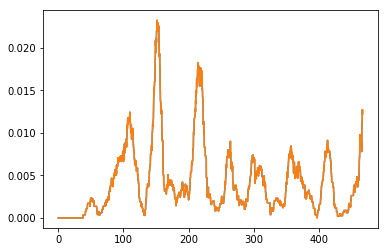

In [20]:
plt.plot(hst['time'],hst['sfr10'])
plt.plot(hstp.time,hstp.sfr10)

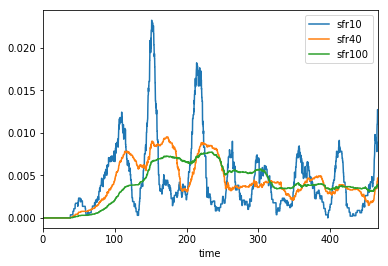

In [21]:
hstp.plot(x='time',y=['sfr10','sfr40','sfr100'])

# Mass Fractions from the history dump



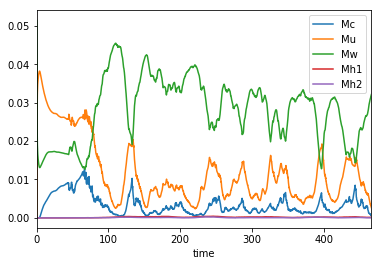

In [22]:
hstp.plot(x='time',y=['Mc','Mu','Mw','Mh1','Mh2'])

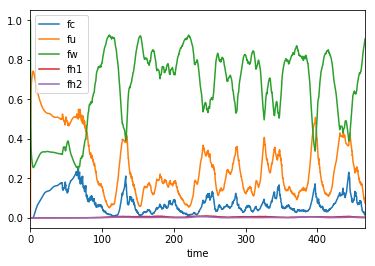

In [23]:
# to convert the mean density of each phase to fraction
phase=['c','u','w','h1','h2']
for p in phase:
    hstp['f'+p]=hstp['M'+p]/hstp['mass']
    hstp.plot(x='time',y='f'+p,ax=plt.gca())

# Scale heights

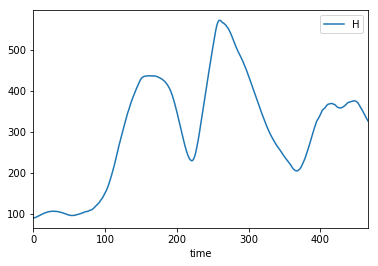

In [24]:
hstp['H']=np.sqrt(hstp['H2']/hstp['mass'])
hstp.plot(x='time',y='H')

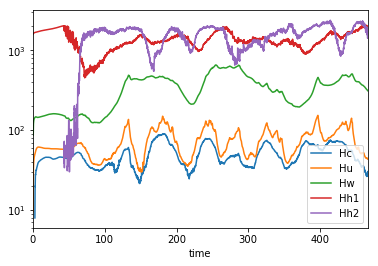

In [25]:
phase=['c','u','w','h1','h2']
for p in phase:
    hstp['H'+p]=np.sqrt(hstp['H2'+p]/hstp['M'+p])
    hstp.plot(x='time',y='H'+p,ax=plt.gca())
plt.yscale('log')

# SN data
* id = id of the host star particle
* time = time of explosion
* age = age of the host star particle; for runaway, this is just indicator of clock. SN exploded as age exceeds zero
* mage = mass-weighted age of the host star particle; for runaway, this is time since runaway creation
* mass = mass of the host star particle. can be used to distinguish runaways
* (x1/x2/x3) = position of the host star particle
* (x1sn/x2sn/x3sn) = position of SN explosion; now it is identical to the star particle position, but possibly we can add a distribution from the center
* (n/v1/v2/v3/e)avg = mean gas properties within SNR
* vol = volume within SNR
* radius = radius of SNR
* SFUV = $\Sigma_{\rm FUV}$ for the host star particle
* SNRate = SN rate calculated based on the host star particle properties
* SNprob = randomly generated probability; this should be smaller than SNRate for explosion
* runaway = 1 if SN from runaways
* parent = parent star cluster id of the runaway
* mode = feedback type
* active = active flag of the host star particle
* fm = mass within the SNR/M_sf

In [26]:
sn=ath_hst.read_w_pandas(hstfilename.replace('hst','sn'))

Reading a history file:/tigress/changgoo/MHD_4pc_new/id0/MHD_4pc_new.sn.p


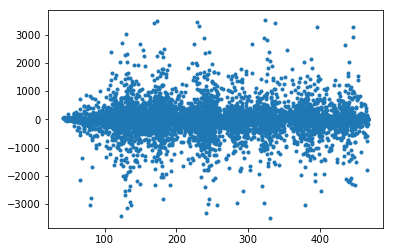

In [27]:
plt.plot(sn['time'],sn['x3'],'.')

In [28]:
runaway=sn['mass'] == 0.0
rsn=sn[runaway]
csn=sn[~runaway]

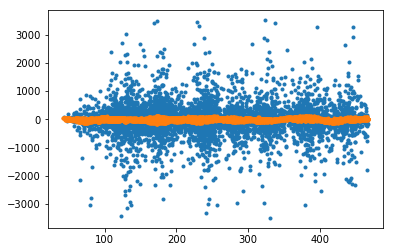

In [29]:
plt.plot(rsn['time'],rsn['x3'],'.')
plt.plot(csn['time'],csn['x3'],'.')